In [1]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os
import matplotlib.transforms as mtransforms
from model_parameters import *

# HV function 
def heav(X):
    if X <= 0:
        return 0
    elif X>0:
        return 1
    
# fixed delayed slope
def decimal_range(start, stop, increment):
    while start < stop: # and not math.isclose(start, stop): Py>3.5
        yield start
        start += increment

In [31]:

def run_(simulated_time):
   
    
    """
    Model parameters
    """
    r_glucose =0.0077
    cell_size=0.65
    f_mean_glucose = 0.55
    f_CV_glucose = 0.1
    S0_mean = 0.60
    S0_CV = 0.1    
    SPN_mean = 0.07
    SPN_CV = 0.03
    SPO_mean = 0.07
    SPO_CV = 0.03
    S0_log = np.random.lognormal(np.log(S0_mean),S0_CV,1)[0]


    """
    Initial state G1
    """
    
    cln3=0
    whi5=1
    sbf=0
    cln2=0
    mbf=0
    clb5=0
    ori=0
    mcm1=0
    clb2G=0
    clb2M=0
    cdc20=0
    cdc5=0
    cdc14=0
    swi5=0
    cdh1=1
    sic1=1
    nrm1=0
    sac = 0
    spoc= 0
    spn_progress = 0
    spoc_progress = 0
    time_init = 0
    divide_status = ""
    init_state = [cln3,whi5,sbf,cln2,mbf,clb5,ori,clb2G,cdc5,mcm1,clb2M,sac,cdc20,spoc,cdc14,swi5,cdh1,sic1,nrm1,
                  time_init,cell_size,S0_log,divide_status,spn_progress,spoc_progress]
    sim_list = [init_state]    
    tr_ = simulated_time
    sac_event = [] # to track sac checkpoint event
    
    
    #
    clb_nd=0
    cdc14_endo_start = 250
   

    for j in range(tr_):
        
        cln3_sum = (cell_size >= S0_log)
        whi5_sum = k60 + k61*cdc14 - k62*cln2 - k63*cln3 
        sbf_sum =  k45 + k47*clb5 + k48*cln2 + k49*cln3 - k46*clb2G - k50*whi5 
        cln2_sum = k30 + k31*mbf + k32*sbf 
        mbf_sum  = k33 + k35*clb5 + k36*cln2 + k37*cln3 - k34*clb2G - k38*nrm1 
        clb5_sum = k25 + k27*mbf + k28*sbf - k29*sic1 - k26*cdc20 
        clb2G_sum = k19 - k20*cdh1 - k21*sic1
        clb2M_sum =  k22 + k24*mcm1 - k23*cdc20
        mcm1_sum = k39 + k41*clb2M + k40*clb2G
        cdc5_sum = k9 + k11*clb2G + k12*clb2M - k10*cdh1 
        cdc20_sum =  k6 + k7*mcm1 - k8*sac 
        cdc14_sum = k1 + k2*cdc5 - k5*spoc - k4*sac - k3*clb2M
        swi5_sum =  k57 + k58*cdc14 + k59*mcm1 
        cdh1_sum = k13 + k14*cdc14 - k16*clb2M - k17*clb5 - k18*cln2 - k15*clb2G
        sic1_sum = k51 + k56*swi5 - k53*clb2M - k54*clb5 - k55*cln2 - k52*clb2G
        nrm1_sum = k42 - k43*cdh1 + k44*mbf



        """
        Binarizing the sum variables by Heaviside function
        """
        cln3_new = heav(cln3_sum)
        whi5_new = heav(whi5_sum)
        sbf_new = heav(sbf_sum)
        cln2_new = heav(cln2_sum)
        mbf_new = heav(mbf_sum)
        clb5_new = heav(clb5_sum)
        mcm1_new = heav(mcm1_sum)
        clb2M_new = heav(clb2M_sum) + clb_nd
        cdc20_new = heav(cdc20_sum) 
        cdc5_new = heav(cdc5_sum)
        cdc14_new = heav(cdc14_sum) 
        swi5_new = heav(swi5_sum)
        cdh1_new = heav(cdh1_sum)
        sic1_new = heav(sic1_sum)
        clb2G_new = heav(clb2G_sum) + clb_nd
        nrm1_new = heav(nrm1_sum)



        """
        Which protein is changed ?
        """

        cln3_update = cln3_new - cln3
        whi5_update = whi5_new - whi5
        sbf_update =  sbf_new - sbf
        cln2_update = cln2_new - cln2
        mbf_update  = mbf_new - mbf
        clb5_update = clb5_new - clb5
        mcm1_update = mcm1_new - mcm1
        clb2M_update = clb2M_new - clb2M
        cdc20_update = cdc20_new - cdc20
        cdc5_update = cdc5_new - cdc5
        cdc14_update = cdc14_new - cdc14
        swi5_update = swi5_new - swi5
        cdh1_update = cdh1_new - cdh1
        sic1_update = sic1_new - sic1
        clb2G_update = clb2G_new - clb2G
        nrm1_update = nrm1_new - nrm1


        """
        Generating propensity ranges
        """

        x1 = abs(cln3_update)
        x2 = x1 + abs(whi5_update)
        x3 = x2 + abs(sbf_update)
        x4 = x3 + abs(cln2_update)
        x5 = x4 + abs(mbf_update)
        x6 = x5 + abs(clb5_update)
        x7 = x6 + abs(mcm1_update)
        x8 = x7 + abs(clb2M_update)
        x9 = x8 + abs(cdc20_update)
        x10 = x9 + abs(cdc5_update)
        x11 = x10 + abs(cdc14_update)
        x12 = x11 + abs(swi5_update)
        x13 = x12 + abs(cdh1_update)
        x14 = x13 + abs(sic1_update)
        x15 = x14 + abs(clb2G_update)
        x16 = x15 + abs(nrm1_update)

        if x16 == 0:
            x17 = 1
        else:
            x17 = x16


        """
        Selecting a single variable to change with a uniform asynchronous update
        """
        sel = random.uniform(0,1)*x17

        y1 = (sel<=x1)
        y2 = (sel>x1)&(sel<=x2)
        y3 = (sel>x2)&(sel<=x3)
        y4 = (sel>x3)&(sel<=x4)
        y5 = (sel>x4)&(sel<=x5)
        y6 = (sel>x5)&(sel<=x6)
        y7 = (sel>x6)&(sel<=x7)
        y8 = (sel>x7)&(sel<=x8)
        y9 = (sel>x8)&(sel<=x9)
        y10 = (sel>x9)&(sel<=x10)
        y11 = (sel>x10)&(sel<=x11)
        y12 = (sel>x11)&(sel<=x12)
        y13 = (sel>x12)&(sel<=x13)
        y14 = (sel>x13)&(sel<=x14)
        y15 = (sel>x14)&(sel<=x15)
        y16 = (sel>x15)&(sel<=x16)
        y17 = (sel>x16)


        """
        Updating time based on the type of chosen protein
        """
       
        delt = np.random.gamma(3,0.3)
        # Adding delay to strain with cdc14 endocycle event    
        if time_init >= cdc14_endo_start:
            if (cdh1 == 0 and cdh1_new == 1 and y13 == 1):
                delt = np.random.gamma(cdh1_delay_ON,cdh1_delay_cv_ON)
            if (cdc5 == 1 and cdc5_new == 0 and y10 == 1):
                delt = np.random.gamma(cdc5_delay,cdc5_delay_cv)
                
               
        time_init = time_init + delt


        """
        Updating size
        """ 
        if(clb2G == 1 and clb2G_new == 0 and y15 == 1):
            
            f = np.random.lognormal(np.log(f_mean_glucose),f_CV_glucose, 1)[0]
            S0_log  = np.random.lognormal(np.log(S0_mean),S0_CV,1)[0]
            cell_size = cell_size*math.exp(r_glucose*delt) * f
            divide_status = "divided !!!"

        else:
            cell_size = cell_size*math.exp(r_glucose*delt)
            divide_status = ""



        """
        Updating protein activity
        """

        cln3 = cln3 + cln3_update*y1
        whi5 = whi5 + whi5_update*y2
        sbf =  sbf + sbf_update*y3
        cln2 = cln2 + cln2_update*y4
        mbf =  mbf + mbf_update*y5
        clb5 = clb5 + clb5_update*y6
        mcm1 = mcm1 + mcm1_update*y7
        clb2M = clb2M + clb2M_update *y8
        cdc20 = cdc20 + cdc20_update*y9
        cdc5 = cdc5 + cdc5_update*y10
        cdc14 = cdc14 + cdc14_update*y11
        swi5 = swi5 + swi5_update*y12
        cdh1 = cdh1 + cdh1_update*y13
        sic1 = sic1 + sic1_update*y14
        clb2G = clb2G + clb2G_update*y15
        nrm1 = nrm1 + nrm1_update*y16
        
    
        """
        ORI begin
        """
    
        # DNA start
        if (clb5 == 1 or clb2M == 1 or clb2G == 1):
            ori = 1
        else:
            ori = 0

        """
        SAC checkpoint
        """
        
        if (ori == 1 and spn_progress < 1):
            sac=1
        else:
            sac=0

        ## spindle assembly progress: start when Clb2M is ON
        if(clb2M == 1 and sac == 1):
            
            num =  np.random.lognormal(np.log(SPN_mean),SPN_CV,1)[0]
            spn_progress += num
            
            if spn_progress >= 1:
                spn_progress = 1
         
        
        """
        SPoC checkpoint
        """
        # 10 = the starting time step for monitoring SAC checkpoint
        if j >= 10:
            t_previous = sac_event[j-2]
            t_current = sac_event[j-1]

            del_sac = t_current-t_previous
        
        if (cdc20 == 1 and del_sac == -1 and spoc_progress < 1):
            spoc = 1
        elif spoc_progress >= 1:
            spoc = 0
        
                
        ## SPoC progress
        if(cdc20 == 1 and spoc == 1):
            num = np.random.lognormal(np.log(SPO_mean),SPO_CV,1)[0]
            spoc_progress += num
            if spoc_progress >= 1:
                spoc_progress = 1
                
                
           
        """
        Resetting progress variables when the progress is done,e.g., spindle progress reset back to zero when anaphase start (cdc20 = 1) 
        """
    
        
        if cdc20 == 1:
            spn_progress = 0
            sac = 0 
        
        if cdc14 == 1:
            spoc_progress = 0
            spoc = 0
            
            
        if time_init >= cdc14_endo_start:
            
            r_galactose =0.0046
            r_glucose = r_galactose #switch to galactose in this strain
            clb_nd=0.5
    
            cdc5_delay = 15
            cdc5_delay_cv = 1.5
            
            cdh1_delay_ON = 15
            cdh1_delay_cv_ON = 1.5
            
     
   
    
        res_ = [cln3,whi5,sbf,cln2,mbf,clb5,ori,clb2G,cdc5,mcm1,clb2M,sac,cdc20,spoc,cdc14,swi5,cdh1,sic1,nrm1,
                time_init,cell_size,S0_log,divide_status,spn_progress,spoc_progress]   
            
        sim_list.append(res_)
        sac_event.append(sac)
        
    return sim_list

In [144]:
dff = run_(350)
node_name = ["cln3","whi5","sbf","cln2", "mbf","clb5","ori", "clb2G", "cdc5","mcm1","clb2M","sac", "cdc20","spoc","cdc14","swi5","cdh1","sic1","nrm1"]
df_sim = pd.DataFrame(dff,columns=node_name+["time","cell_size","critical_size","divide","SPN","SPOC"])

In [145]:
cdh1_p = np.array(df_sim["cdh1"])
clb2M_p = np.array(df_sim["clb2M"])
clb2G_p = np.array(df_sim["clb2G"])
cdc5_p = np.array(df_sim["cdc5"])
cdc14_p = np.array(df_sim["cdc14"])
mcm1_p = np.array(df_sim["mcm1"])
ts = np.array(df_sim["time"])
cs = np.array(df_sim["cell_size"])

In [146]:
# plot protein activities + adjust slope from delay

In [147]:
dict_ = {"Cdh1":cdh1_p,"Clb2G":clb2G_p,"Clb2M":clb2M_p,"Cdc5":cdc5_p,"Cdc14":cdc14_p,"Mcm1":mcm1_p}
activities_list = []
for i in dict_.keys():
    dat = pd.DataFrame(dict_[i],columns=["value"])
    dat["index"] = i
    dat["ts"] = ts
    activities_list.append(dat)
    
dat_cat = pd.concat(activities_list)
table = pd.pivot_table(dat_cat, values='value', index="index",columns="ts")

In [148]:
time_list = []
ts_col = table.columns.tolist()
for ts_df in range(len(ts_col)-1):
    
    old_index = ts_df
    new_index = ts_df+1
    
    old_c = ts_col[old_index]
    new_c = ts_col[new_index]
  
    int_  = new_c - old_c
    if int_ >= 3:
        time_list.append(ts_df)
    

In [149]:
df_list = []
for _ in time_list:
    
    start_time = _
    end_time = _ + 1
    
    st_real = ts_col[start_time]
    end_real = ts_col[end_time]
    
    #add time
    add_time = [in_time for in_time in decimal_range(st_real,end_real,1e-2)]
    df_p = pd.concat([table.iloc[:,_]]*len(add_time),axis=1)
    df_p.columns = add_time
    df_list.append(df_p)
    

In [159]:
df_add = pd.concat(df_list,axis=1)
df_add_1 = pd.concat([table,df_add],axis=1)
df_plot = df_add_1.reset_index().melt(id_vars="index")
cs_df=pd.DataFrame(cs,columns=["value"])
cs_df["variable"] = ts
cs_df["index"] = "cell_size"
all_df = pd.concat([df_plot,cs_df]).reset_index().iloc[:,1:]
#all_df.to_csv("../data/Fig6A.csv")

In [ ]:
#Fi6 plot

/var/folders/m_/w2wt9y5n2bg0k03_n88pwc9r0000gn/T/ipykernel_5464/2415542526.py:35: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_time = pd.read_csv("../data/Fig6B.csv")


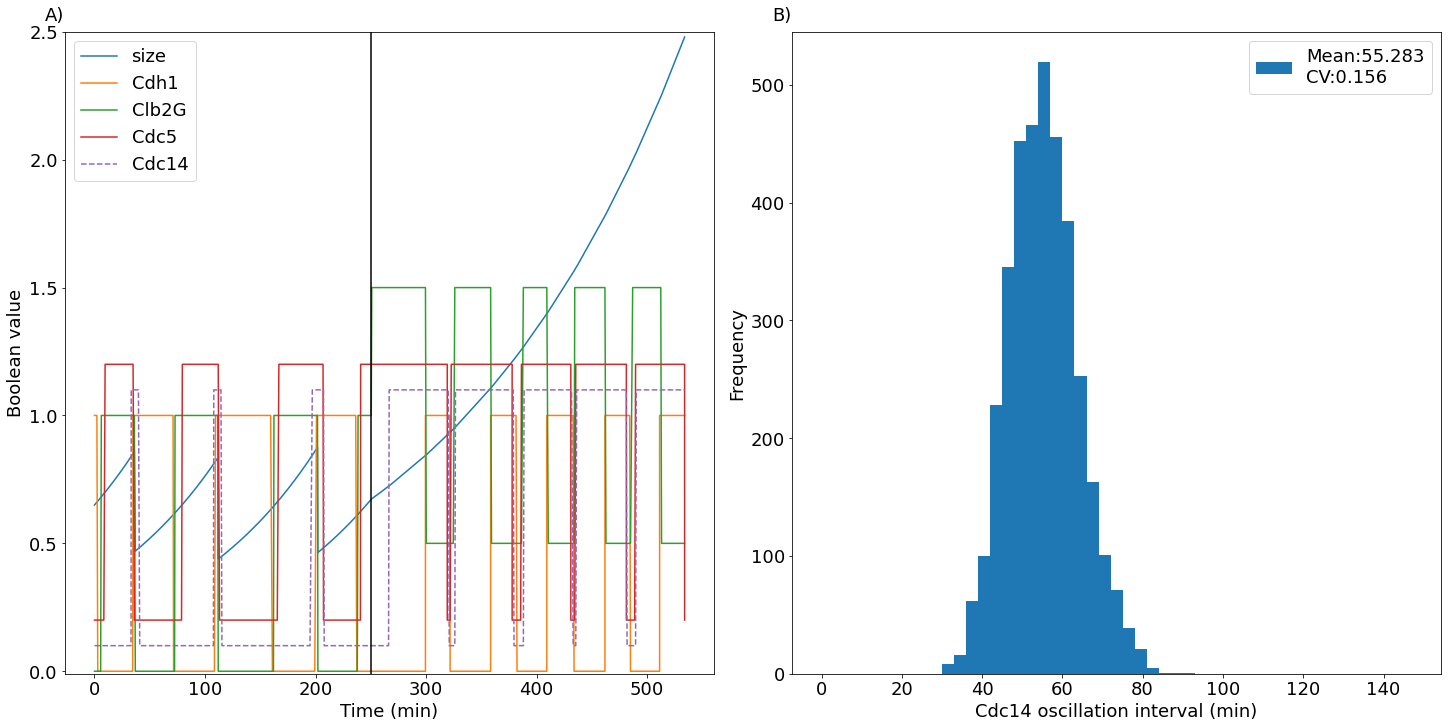

In [3]:
fig = plt.figure(layout= 'constrained', figsize=(20,10))
axs = fig.subplot_mosaic([['A)', 'B)']])
XX=18
"""
A
"""
df_size = pd.read_csv("../data/Fig6A.csv")
def line_(X):
    FD = df_size.query("index == @X").sort_values(by="variable")
    FD2 = FD.variable
    FD3 = FD.value
    return [FD2,FD3]

axs["A)"].plot(line_("cell_size")[0],line_("cell_size")[1], label ='size')
axs["A)"].plot(line_("Cdh1")[0],line_("Cdh1")[1], label ='Cdh1')
axs["A)"].plot(line_("Clb2G")[0],line_("Clb2G")[1], label ="Clb2G")
axs["A)"].plot(line_("Cdc5")[0],line_("Cdc5")[1]+0.2, label ='Cdc5')
axs["A)"].plot(line_("Cdc14")[0],line_("Cdc14")[1]+0.1, label ='Cdc14',linestyle='--')
axs["A)"].set_ylim(-0.01,2.5)
axs["A)"].axvline(x=250,color='black')
axs["A)"].legend(loc="upper left",fontsize=XX)
axs["A)"].set_xlabel("Time (min)",fontsize=XX)
axs["A)"].set_ylabel("Boolean value",fontsize=XX)
axs['A)'].tick_params(labelsize=XX)


"""
B
"""

#dff_time = run_(100000)
#node_name = ["cln3","whi5","sbf","cln2", "mbf","clb5","ori", "clb2G", "cdc5","mcm1","clb2","sac", "cdc20","spoc","cdc14","swi5","cdh1","sic1","nrm1"]
#df_time = pd.DataFrame(dff_time,columns=node_name+["time","cell_size","critical_size","divide","SPN","SPOC"])
#df_time.to_csv("fig_all/fig6B_plot.csv")
df_time = pd.read_csv("../data/Fig6B.csv")
df5 = df_time.iloc[1000:,:][["time","cdc14"]]
X = df5.cdc14.to_numpy()

peak_list = []
for cc in range(len(X)-1):
    old_index = cc
    new_index = cc+1
    
    old_c = X[old_index]
    new_c = X[new_index]
    
    sub_ = new_c-old_c
    
    if sub_ == -1:
        peak_list.append(cc)
        
df6 = df5.iloc[peak_list[1:],:]
diff_peak = list(df6['time'] - df6['time'].shift())[1:][::2]


axs["B)"].hist(diff_peak,bins=[_ for _ in range(0,150,3)],label="Mean:"+str(round(np.mean(diff_peak),3))+"\nCV:"+str(round(np.std(diff_peak)/np.mean(diff_peak),3)))
axs["B)"].set_xlabel("Cdc14 oscillation interval (min)",fontsize=XX)
axs["B)"].set_ylabel("Frequency",fontsize=XX)
axs["B)"].legend(fontsize=XX)
axs['B)'].tick_params(labelsize=XX)

for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize=XX, va='bottom')

plt.savefig('../figures/Fig6.pdf',format="pdf", bbox_inches="tight")
plt.show()
